In [39]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import prettytable as pt
from scipy import integrate

# Лабораторная №3

### Линейная интерполяция

In [40]:
class Interpolation:

    def __init__(self, i = 1):
        
        self.koefs = None

        self.readCSV("table.csv", i)

        print(f"Коэффициенты: {self.koefs[0]}x + {self.koefs[1]}")

    def readCSV(self, fileName, i):
        
        df = pd.read_csv(fileName)

        x = np.log(df['t'].to_numpy())
        y = np.log(df[f'var{i}'].to_numpy())
        
        koefs = np.zeros((y.size - 1, 2))

        for i in range(1, y.size):
            koefs[i - 1, 0] = (y[i] - y[i - 1]) / (x[i] - x[i - 1])
            koefs[i - 1, 1] = y[i - 1] - koefs[i - 1, 0] * x[i - 1]

        self.koefs = [np.mean(koefs[:, 0]), 
                      np.mean(koefs[:, 1])]
    
    def graph(self, fileName = "table.csv"):

        df = pd.read_csv(fileName)

        x1 = df['t'].to_numpy()
        y1 = df[f'var{1}'].to_numpy()
        y2 = df[f'var{2}'].to_numpy()

        plt.plot(x1, y1, color = 'green')
        plt.plot(x1, y2, color = 'blue')

        plt.show()
        
    def getResult(self, x):
        x = np.log(x)
        
        return np.exp(self.koefs[0] * x + self.koefs[1])

### Исходная система уравнений

In [41]:
class Equation:

    def __init__(self):
        self.R = 0.35
        self.Tw = 2000
        self.T0 = 1e4
        self.p = 4
        self.c = 3e10

        self.cur_z = -1
        
        self.interpolation = Interpolation()

    def T(self, z):
        return (self.Tw - self.T0) * z ** self.p + self.T0

    def u_p(self, z):
        return 3.084e-4 / (np.exp(4.799e4 / self.T(z)) - 1)

    def k(self, z):
        return self.interpolation.getResult(self.T(z))
    
    def dU(self, z, F):
        return -3 * self.R * self.k(z) * F / self.c
    
    def dF(self, z, u, F):

        part = self.c * self.k(z) * (self.u_p(z) - u) * self.R

        return part - F / z
    
    def kpd(self, z):
        return self.c / (3 * self.k(z))
    
    def kappa(self, z, h):
        return (self.kpd(z) + self.kpd(z + h)) / 2

    def pFunc(self, z):
        return self.c * self.k(z)
    
    def f(self, z):
        return self.c * self.k(z) * self.u_p(z)
    
    def integral(self, z, h):
        return ((z + h / 2) ** 2 - (z - h / 2) ** 2) / 2

### Решение системы ОДУ

In [42]:
class Solver:

    def __init__(self, system : Equation):
        
        self.N = 1000

        z0 = 0
        zMax = 1

        self.z = np.linspace(z0, zMax, self.N)

        self.step = (zMax - z0) / self.N
        self.system = system

        self.Fmax = 0

    def leftRun(self, c, d, e, f):

        a = np.zeros(self.N)
        b = np.zeros(self.N)

        u = np.zeros(self.N)
        
        for i in range(self.N - 1, 0, -1):
    
            if i == self.N - 1:
                a[i - 1] = -c[i] / d[i]  
                b[i - 1] = f[i] / d[i]  

            else:
                zn = e[i] * a[i] + d[i]  

                a[i - 1] = -c[i] / zn  
                b[i - 1] = (f[i] - e[i] * b[i]) / zn 

        for i in range(self.N):

            if i == 0:
                u[i] = (f[i] - e[i] * b[i]) / (e[i] * a[i] + d[i])  
            else:
                u[i] = a[i - 1] * u[i - 1] + b[i - 1]
    
        return u
    
    def rightRun(self, c, d, e, f):

        # прогоночные коэффициенты
        a = np.zeros(self.N)
        b = np.zeros(self.N)

        # решение системы
        u = np.zeros(self.N)

        # прямой ход : находим a, b
        for i in range(self.N - 1):

            if i == 0:
                a[i + 1] = -e[i] / d[i]
                b[i + 1] = f[i] / d[i]
            else:
                zn = c[i] * a[i] + d[i]

                a[i + 1] = -e[i] / zn
                b[i + 1] = (f[i] - c[i] * b[i]) / zn

        # обратный ход : находим u
        for i in range(self.N - 1, -1, -1):

            if i == self.N - 1:
                u[i] = (f[i] - c[i] * b[i]) / (c[i] * a[i] + d[i])
            else:   
                u[i] = a[i + 1] * u[i + 1] + b[i + 1]
        
        return u
    
    def F(self, u):

        z = self.z

        u_p = self.system.u_p(z)
        k = self.system.k(z)

        func = k * (u_p - u) * z

        n = len(z)
        F = np.zeros_like(z)
        for i in range(1, n):

            # ручная
            # for j in range(1, i):
            #     F[i] += self.step * (k[j] * (u_p[j] - u[j]) * z[j] + k[j - 1] * (u_p[j - 1] - u[j - 1]) * z[j - 1]) / 2 
            # F[i] *= self.system.c * self.system.R / z[i]
            
            # автоматическая
            F[i] = self.system.c * self.system.R * integrate.trapezoid(func[:i + 1], x=z[:i + 1]) / z[i]

        return F
    
    def Solve(self):  

        f = np.zeros(self.N)
        c = np.zeros(self.N)
        d = np.zeros(self.N)
        e = np.zeros(self.N)

        for i in range(self.N):

            z = self.z[i]
            halfStep = self.step / 2

            if i == 0:
                d[i] = -(z + halfStep) * self.system.kappa(z, self.step) / self.system.R ** 2
                e[i] = -d[i]
                f[i] = 0

            elif i == self.N - 1:
                c[i] = (z - halfStep) * self.system.kappa(z, -halfStep) / self.system.R ** 2
                d[i] = -c[i] - z * 0.393 * self.system.c * self.step / self.system.R
                f[i] = 0

            else:
                commPart = self.system.R ** 2 * self.step
                
                c[i] = (z - halfStep) * self.system.kappa(z, -self.step) / commPart
                e[i] = (z + halfStep) * self.system.kappa(z, self.step) / commPart
                
                d[i] = -(c[i] + e[i] + self.system.pFunc(z) * self.system.integral(z, self.step))
                
                f[i] = -self.system.f(z) * self.system.integral(z, self.step)

        # начинаем прогонку
        # u = self.rightRun(c, d, e, f)
        u = self.leftRun(c, d, e, f)
        
        return u, self.F(u)


### Результаты

In [43]:
eq = Equation()
solve = Solver(eq)

u, F = solve.Solve()

z = solve.z
k = eq.k(z)
u_p = eq.u_p(z)

Коэффициенты: 2.9999969566309646x + -27.606307905254777


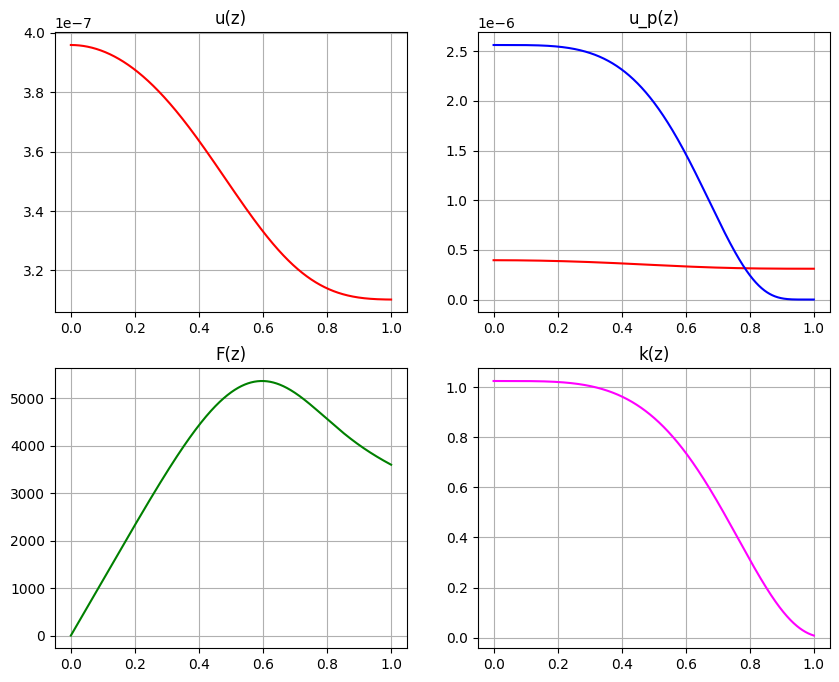

In [44]:
# Графики

fig, axs = plt.subplots(2, 2, figsize = (10, 8))

# u(z)
axs[0, 0].plot(z, u, "red")
axs[0, 0].set_title("u(z)")

# u_p(z)
axs[0, 1].plot(z, u, "red")
axs[0, 1].plot(z, u_p, "blue")
axs[0, 1].set_title("u_p(z)")

# F(z)
axs[1, 0].plot(z, F, "green")
axs[1, 0].set_title("F(z)")

# k(z)
axs[1, 1].plot(z, k, "magenta")
axs[1, 1].set_title("k(z)")

for ax in axs.flat:
    ax.grid(True)

plt.show()

### Правая прогонка

In [46]:
# Метод прогонки решения СЛАУ в виде 3х диагональной матрицы
# Ax = F A - матрица

A = np.array([[3, 1, 0],
              [-1, 4, 2],
              [0, 2, 3]])

f = np.array([1, -3, 5])

n = f.size

c = np.hstack(([0], np.diag(A, k = -1)))
d = np.diag(A, k = 0)
e = np.diag(A, k = 1)

a = np.zeros(n)
b = np.zeros(n)
x = np.zeros(n)

# прямой ход : находим прогоночные коэффициенты
for i in range(n - 1):

    if i == 0:
        a[i + 1] = -e[i] / d[i]
        b[i + 1] = f[i] / d[i]
    else:
        zn = c[i] * a[i] + d[i]

        a[i + 1] = -e[i] / zn
        b[i + 1] = (f[i] - c[i] * b[i]) / zn

# обратный ход : находим иксы
for i in range(n - 1, -1, -1):

    if i == n - 1:
        x[i] = (f[i] - c[i] * b[i]) / (c[i] * a[i] + d[i])
    else:   
        x[i] = a[i + 1] * x[i + 1] + b[i + 1]

print(x)

[ 0.         -0.33333333 -0.46153846] [ 0.          0.33333333 -0.61538462]
[ 1. -2.  3.]


### Левая прогонка

In [47]:
A = np.array([[3, 1, 0],
              [-1, 4, 2],
              [0, 2, 3]])

f = np.array([1, -3, 5])

n = f.size

c = c = np.hstack(([0], np.diag(A, k = -1)))
d = np.diag(A, k=0)
e = np.diag(A, k=1)

a = np.zeros(n)
b = np.zeros(n)
x = np.zeros(n)

for i in range(n - 1, 0, -1):
    
    if i == n - 1:
        a[i - 1] = -c[i] / d[i]  
        b[i - 1] = f[i] / d[i]  

    else:
        zn = e[i] * a[i] + d[i]  

        a[i - 1] = -c[i] / zn  
        b[i - 1] = (f[i] - e[i] * b[i]) / zn 

for i in range(n):

    if i == 0:
        x[i] = (f[i] - e[i] * b[i]) / (e[i] * a[i] + d[i])  
    else:
        x[i] = a[i - 1] * x[i - 1] + b[i - 1]

print(x)